<a href="https://colab.research.google.com/github/Daniel120622/Final-Year-Project/blob/main/Cloth%20Classifcation%20for%20fyp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Machine Learning**

# Start Training

In [ ]:
!pip install torch torchvision pandas


**Mount Google Drive**

This code mounts your Google Drive to the Colab environment, allowing you to access files stored in your Drive.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


**Import Libraries**
Here, you import necessary libraries:

torch for the core PyTorch functionalities.
torch.nn for neural network modules.
torch.optim for optimization algorithms.
torchvision for datasets and image transformations.
DataLoader for loading data in batches.
os for interacting with the operating system, such as file paths.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, random_split
import os
from diffusers.utils import load_image


**Define Paths**

This sets the base directory where your dataset is stored.

In [ ]:
base_dir = '/content/drive/MyDrive/Final Year Project/dataset/sorted_images'


**Data Loading**

This section handles the following:

Defines transformations to apply to the images, such as resizing, cropping, flipping, and normalization.
Creates datasets using datasets.ImageFolder with the defined transformations.
Loads data into DataLoader objects for batch processing.
Calculates the size of each dataset (training and validation).
Gets the class names.
Sets the device to GPU if available, otherwise CPU.


In [ ]:
import os
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader


# Define the transformations for the images
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

image_datasets = {x: datasets.ImageFolder(os.path.join(base_dir, x), data_transforms[x])
                  for x in ['train', 'val']}

dataloaders = {x: DataLoader(image_datasets[x], batch_size=32, shuffle=True, num_workers=4)
               for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(f"Training set size: {dataset_sizes['train']}")
print(f"Validation set size: {dataset_sizes['val']}")
print(f"Classes: {class_names}")


Training set size: 4314
Validation set size: 1089
Classes: ['Blazer', 'Blouse', 'Body', 'Dress', 'Hat', 'Hoodie', 'Longsleeve', 'Not sure', 'Other', 'Outwear', 'Pants', 'Polo', 'Shirt', 'Shoes', 'Shorts', 'Skip', 'Skirt', 'T-Shirt', 'Top', 'Undershirt']


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(



**Define the Model**




Loads a pre-trained ResNet-18 model.
Modifies the final fully connected layer to match the number of classes.
Moves the model to the appropriate device (GPU or CPU).
Defines the loss function (cross-entropy loss).
Sets up the optimizer (Adam
).

In [ ]:
model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(class_names))

model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 182MB/s]


**Train the Model**


Loops through the specified number of epochs.
For each epoch, loops through the training and validation phases.
Sets the model to training or evaluation mode.
Initializes running loss and correct predictions counters.
For each batch, moves data to the appropriate device, zeroes the gradients, performs forward pass, computes loss, performs backward pass and updates weights (only in training phase).
Updates running loss and correct predictions counters.
Calculates and prints the loss and accuracy for each epoch.

In [ ]:
def train_model(model, criterion, optimizer, num_epochs=10):
    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

    return model

model = train_model(model, criterion, optimizer, num_epochs=10)


**Evaluate the Model**

This function:

Sets the model to evaluation mode.
Initializes a counter for correct predictions.
Disables gradient computation for efficiency.
Loops through the validation dataset, moves data to the appropriate device, performs forward pass, and updates the correct predictions counter.
Calculates and prints the overall validation accuracy.

In [ ]:
def evaluate_model(model, dataloader, dataset_size):
    model.eval()
    running_corrects = 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            running_corrects += torch.sum(preds == labels.data)

    accuracy = running_corrects.double() / dataset_size
    print(f'Accuracy: {accuracy:.4f}')
    return accuracy

val_accuracy = evaluate_model(model, dataloaders['val'], dataset_sizes['val'])
print(f'Validation Accuracy: {val_accuracy:.4f}')

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Accuracy: 0.7392
Validation Accuracy: 0.7392


In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/Final Year Project/Final_model.pth')

# If the result is not good as expected

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models

# Load the saved model
model_path = '/content/drive/MyDrive/Final Year Project/Final_model.pth'

# Define the model architecture
model = models.resnet18(pretrained=False)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(class_names))

# Load the state dictionary
model.load_state_dict(torch.load(model_path))
model = model.to(device)


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [ ]:
# Continue training for additional epochs
additional_epochs = 10  # Number of additional epochs to train
model = train_model(model, criterion, optimizer, num_epochs=additional_epochs)


In [ ]:
def evaluate_model(model, dataloaders):
    model.eval()
    running_corrects = 0

    with torch.no_grad():
        for inputs, labels in dataloaders['val']:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            running_corrects += torch.sum(preds == labels.data)

    total_acc = running_corrects.double() / dataset_sizes['val']
    print(f'Validation Accuracy: {total_acc:.4f}')

evaluate_model(model, dataloaders)


In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/Final Year Project/overfitting_Final_model.pth')

# Input a new picture to test the model

Load the saved model:
First, load the saved model weights.

In [ ]:
model = models.resnet18(pretrained=False)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(class_names))

model.load_state_dict(torch.load('/content/drive/MyDrive/Final Year Project/Final_model.pth'))
model = model.to(device)
model.eval()


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
<ipython-input-9-75750329da7e>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
from PIL import Image

def preprocess_image(image_path):
    image = Image.open(image_path)
    transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    image = transform(image).unsqueeze(0)  # Add batch dimension
    return image


Make a prediction:
Pass the preprocessed image through the model to get the prediction.

In [ ]:
def predict_image(model, image_path):
    image = preprocess_image(image_path)
    image = image.to(device)

    with torch.no_grad():
        outputs = model(image)
        _, preds = torch.max(outputs, 1)

    return class_names[preds[0]]

# Test with a new image
test_image_path = '/content/T-shirt.jpg'
prediction = predict_image(model, test_image_path)
print(f'The predicted class is: {prediction}')


The predicted class is: Outwear


In [ ]:
import torch
import matplotlib.pyplot as plt

# Load the checkpoint
checkpoint = torch.load('/content/drive/MyDrive/Final Year Project/Final_model.pth', map_location=torch.device('cpu'))

# Print all keys and their types
print("Checkpoint contents:")
for key, value in checkpoint.items():
    print(f"Key: {key}")
    print(f"Type: {type(value)}")
    if isinstance(value, dict):
        print("Dictionary contents:")
        for k, v in value.items():
            print(f"  Subkey: {k}")
            print(f"  Type: {type(v)}")
    print("---")

# Try different common key patterns
possible_loss_keys = [
    'loss', 'losses', 'train_loss', 'val_loss',
    'training_loss', 'validation_loss',
    'loss_history', 'history', 'metrics',
    'train_losses', 'val_losses'
]

found_losses = {}
for key in possible_loss_keys:
    if key in checkpoint:
        found_losses[key] = checkpoint[key]

if found_losses:
    print("\nFound loss values:")
    for key, value in found_losses.items():
        print(f"{key}:")
        print(value)

    # Plot the first found loss values
    key, values = next(iter(found_losses.items()))
    if isinstance(values, (list, tuple, torch.Tensor)):
        plt.figure(figsize=(10, 6))
        epochs = range(len(values))
        plt.plot(epochs, values, label=key)
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title(f'Loss Values ({key})')
        plt.legend()
        plt.grid(True)
        plt.show()
else:
    print("\nNo standard loss keys found. Here's the full checkpoint structure:")
    def explore_dict(d, prefix=''):
        for k, v in d.items():
            print(f"{prefix}Key: {k}")
            if isinstance(v, dict):
                explore_dict(v, prefix + '  ')
            elif isinstance(v, (list, tuple, torch.Tensor)):
                print(f"{prefix}Value type: {type(v)}")
                print(f"{prefix}Length/Shape: {len(v) if isinstance(v, (list, tuple)) else v.shape}")

    explore_dict(checkpoint)

<ipython-input-8-1c548598d6d2>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('/content/drive/MyDrive/Final Year Project/Final_model.pth', map_loca

Checkpoint contents:
Key: conv1.weight
Type: <class 'torch.Tensor'>
---
Key: bn1.weight
Type: <class 'torch.Tensor'>
---
Key: bn1.bias
Type: <class 'torch.Tensor'>
---
Key: bn1.running_mean
Type: <class 'torch.Tensor'>
---
Key: bn1.running_var
Type: <class 'torch.Tensor'>
---
Key: bn1.num_batches_tracked
Type: <class 'torch.Tensor'>
---
Key: layer1.0.conv1.weight
Type: <class 'torch.Tensor'>
---
Key: layer1.0.bn1.weight
Type: <class 'torch.Tensor'>
---
Key: layer1.0.bn1.bias
Type: <class 'torch.Tensor'>
---
Key: layer1.0.bn1.running_mean
Type: <class 'torch.Tensor'>
---
Key: layer1.0.bn1.running_var
Type: <class 'torch.Tensor'>
---
Key: layer1.0.bn1.num_batches_tracked
Type: <class 'torch.Tensor'>
---
Key: layer1.0.conv2.weight
Type: <class 'torch.Tensor'>
---
Key: layer1.0.bn2.weight
Type: <class 'torch.Tensor'>
---
Key: layer1.0.bn2.bias
Type: <class 'torch.Tensor'>
---
Key: layer1.0.bn2.running_mean
Type: <class 'torch.Tensor'>
---
Key: layer1.0.bn2.running_var
Type: <class 'torch.T

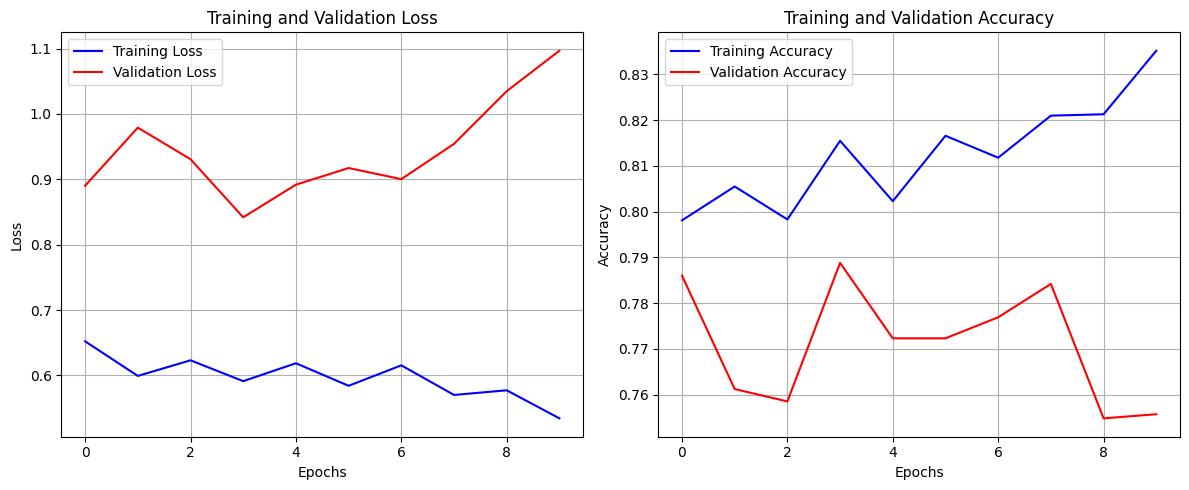

Best Training Loss: 0.5343 (Epoch 9)
Best Validation Loss: 0.8419 (Epoch 3)
Best Training Accuracy: 0.8352 (Epoch 9)
Best Validation Accuracy: 0.7888 (Epoch 3)


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Extract values from the training history
train_loss = [0.6521, 0.5992, 0.6231, 0.5912, 0.6186, 0.5841, 0.6154, 0.5701, 0.5772, 0.5343]
val_loss = [0.8902, 0.9791, 0.9308, 0.8419, 0.8918, 0.9173, 0.9003, 0.9543, 1.0349, 1.0968]
train_acc = [0.7981, 0.8055, 0.7983, 0.8155, 0.8023, 0.8166, 0.8118, 0.8210, 0.8213, 0.8352]
val_acc = [0.7860, 0.7612, 0.7585, 0.7888, 0.7723, 0.7723, 0.7769, 0.7842, 0.7548, 0.7557]

epochs = range(10)

# Create subplots for loss and accuracy
plt.figure(figsize=(12, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, 'b-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Print best values
print(f"Best Training Loss: {min(train_loss):.4f} (Epoch {train_loss.index(min(train_loss))})")
print(f"Best Validation Loss: {min(val_loss):.4f} (Epoch {val_loss.index(min(val_loss))})")
print(f"Best Training Accuracy: {max(train_acc):.4f} (Epoch {train_acc.index(max(train_acc))})")
print(f"Best Validation Accuracy: {max(val_acc):.4f} (Epoch {val_acc.index(max(val_acc))})")